In [ ]:
# --- Bloomberg Excel loader (connection-based; per-row inserts) ---
# this code runs in conjuction with the Price_History_HC sheet - it takes a couple of minutes to run
# this sheet is a copy and paste from the UK_markets_analysis sheet
# version 1 - JCB 20250912
#
# look  to connect directly to Bloomberg

import sys, sqlite3
sys.path.append("/Users/jcb/Documents/bond_project")  # adjust if needed

import pandas as pd
from datetime import datetime, timedelta

from jcb_bond_project.database.query import resolve_isin_from_alt_id
from jcb_bond_project.database.insert import insert_instrument_data   # expects ONE InstrumentData
from jcb_bond_project.models.instrument_data import InstrumentData

DB_PATH   = "/Volumes/PROJECT_JCB/bond_project/jcb_db.db"
FILE_PATH = "Price_History_HC.xlsx"

# Config
PRICE_AS_CLEAN = True      # PX_LAST -> 'clean_price' (else 'price')
SESSION        = "close"   # mark close session in attrs
RESOLUTION     = "daily"   # your queries expect 'daily'
BATCH_SIZE     = 5000      # just controls memory; inserts are still per-row

def excel_serial_to_date(serial):
    return (datetime(1899, 12, 30) + timedelta(days=float(serial))).date()

def clean_date(cell):
    try:
        if isinstance(cell, (int, float)) and 10000 < float(cell) < 60000:
            return excel_serial_to_date(cell)
        d = pd.to_datetime(cell, errors="coerce")
        return None if pd.isna(d) else d.date()
    except Exception:
        return None

def map_bbg_dtype(raw: str) -> str:
    r = (raw or "").strip().lower()
    if r == "yld_ytm_mid":
        return "yield"
    if r == "px_dirty_mid":
        return "dirty_price"
    if r == "px_last":
        return "clean_price" if PRICE_AS_CLEAN else "price"
    # extend mappings as needed (e.g., DUR_MID -> duration_modified)
    return r or "price"

def unit_for_dtype(dt: str):
    if dt == "yield": return "percent"
    if dt in ("clean_price","dirty_price","price"): return "per_100"
    if dt in ("z_spread","ois_oas"): return "bps"
    if dt in ("duration_modified","modified_duration"): return "years"
    return None

# Load workbook (4-column block layout)
df = pd.read_excel(FILE_PATH, header=None)

start_col = 2
errors   = []
inserted = 0
skipped  = 0
batch    = []

def flush_batch(conn, batch):
    global inserted, skipped
    for row in batch:
        try:
            res = insert_instrument_data(conn, row)  # your helper expects ONE InstrumentData
            inserted += 1 if res == "inserted" else 0
            skipped  += 1 if res != "inserted" else 0
        except Exception as e:
            errors.append(f"{row.instrument_id} @ {row.data_date}: {e}")

conn = sqlite3.connect(DB_PATH)
try:
    # sensible PRAGMAs
    conn.execute("PRAGMA foreign_keys=ON;")
    conn.execute("PRAGMA journal_mode=WAL;")
    conn.execute("PRAGMA synchronous=NORMAL;")
    conn.execute("PRAGMA busy_timeout=5000;")

    conn.execute("BEGIN;")

    col = start_col
    while col < df.shape[1]:
        try:
            bloomberg_code = str(df.iloc[4, col]).strip()
            short_code     = str(df.iloc[5, col]).strip()
            data_type_raw  = str(df.iloc[6, col]).strip()
            data_type      = map_bbg_dtype(data_type_raw)

            # Resolve ISIN using the SAME connection
            isin = resolve_isin_from_alt_id(conn, bloomberg_code, source="Bloomberg")
            if not isin:
                errors.append(f"{bloomberg_code}: ISIN not found")
                col += 4
                continue

            date_series  = df.iloc[10:, col]
            value_series = df.iloc[10:, col + 1]

            for date_cell, value_cell in zip(date_series, value_series):
                d = clean_date(date_cell)
                if d is None or pd.isna(value_cell):
                    continue
                try:
                    val = float(value_cell)
                except Exception:
                    continue

                batch.append(InstrumentData(
                    instrument_id=isin,
                    data_date=d,
                    data_type=data_type,
                    value=val,
                    source="Bloomberg",
                    resolution=RESOLUTION,
                    unit=unit_for_dtype(data_type),
                    attrs={"session": SESSION}
                ))

                if len(batch) >= BATCH_SIZE:
                    flush_batch(conn, batch)
                    batch.clear()

        except Exception as outer_e:
            errors.append(f"Column {col}: {outer_e}")

        col += 4  # next block

    if batch:
        flush_batch(conn, batch)
        batch.clear()

    conn.execute("COMMIT;")
except Exception as e:
    conn.execute("ROLLBACK;")
    raise
finally:
    conn.close()

print("✅ Finished loading Bloomberg historical data (connection-based, per-row insert).")
print(f"   Inserted: {inserted} | Skipped: {skipped} | Errors: {len(errors)}")
for e in errors[:10]:
    print(" -", e)
if len(errors) > 10:
    print(f"   ...and {len(errors)-10} more.")

In [ ]:
# --- Tradeweb csv loader (connection-based; per-row inserts) ---
# this code runs in conjuction with the Tradeweb exports sheet - it takes a couple of minutes to run
# version 1 - JCB 20250912
#
# look have an automated way to download the data from Tradeweb

from jcb_bond_project.database.db import get_conn
from jcb_bond_project.database.normalise_types import seed_mappings  # ensure up-to-date aliases
from jcb_loaders.load_tradeweb import load_tradeweb_csv_mapped

DB_PATH = "jcb_db.db"
CSV = "E:/bond_project/tradeweb_data/tradeweb_GB00B1VWPJ53.csv"

# 0) refresh mappings (includes Tradeweb aliases)
with get_conn(DB_PATH) as conn:
    seed_mappings(conn)

# 1) Dry-run (no inserts): confirms parsing + mapping coverage
load_tradeweb_csv_mapped(CSV, DB_PATH, dry_run=True)

# 2) Real load (canonical types written directly to instrument_data)
ins, skip, err, n_unmapped = load_tradeweb_csv_mapped(CSV, DB_PATH, allow_unmapped=False)

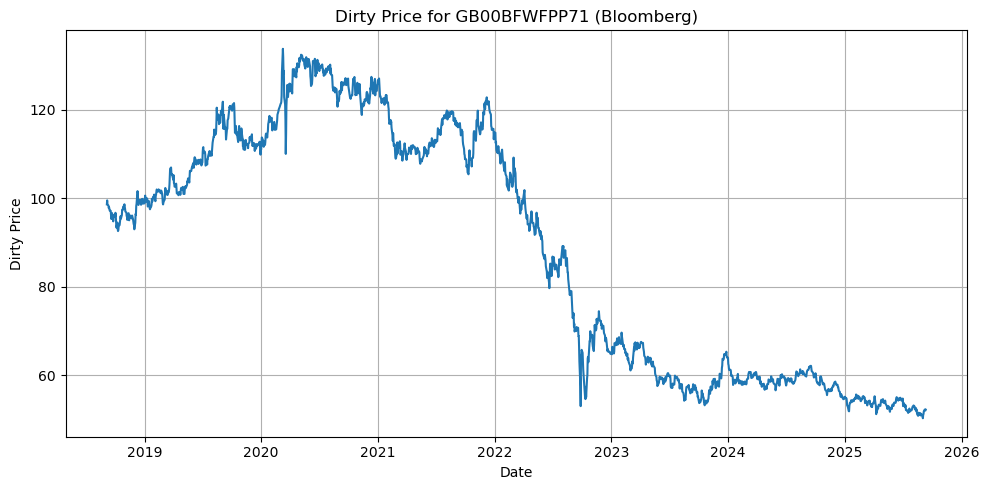

In [ ]:
# A graphing tool that gets data from the jcb_db database
# Verion 1 - JCB 20250912
#
# Look to have a more interactive plotting tool on the internet


import pandas as pd
import matplotlib.pyplot as plt

import importlib
import jcb_bond_project.database.query  # for reload during iterative dev
importlib.reload(jcb_bond_project.database.query)

from jcb_bond_project.database.db import get_conn
from jcb_bond_project.database.query import load_instrument_data

DB_PATH = "jcb_db.db"

def plot_instrument_timeseries(isin: str, source: str, data_type: str = "yield", db_path: str = DB_PATH):
    # open/commit/close handled here (top level)
    with get_conn(db_path) as conn:
        df = load_instrument_data(
            conn,
            instrument_id=isin,
            source=source,
            data_type=data_type,     # e.g. "yield", "clean_price", "dirty_price", ...
            long_format=True,        # default; included for clarity
            parse_dates=False        # we'll parse below
        )

    if df.empty:
        print(f"❌ No data found for ISIN {isin} and type '{data_type}'.")
        return

    # ensure datetime for plotting
    df["data_date"] = pd.to_datetime(df["data_date"], errors="coerce")

    plt.figure(figsize=(10, 5))
    plt.plot(df["data_date"], df["value"])
    plt.title(f"{data_type.replace('_', ' ').title()} for {isin} ({source})")
    plt.xlabel("Date")
    plt.ylabel(data_type.replace('_', ' ').title())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# example call
# If your stored data types are "clean_price"/"dirty_price", use one of those instead of "price"
plot_instrument_timeseries("GB00BFWFPP71", source="Bloomberg", data_type="dirty_price")

In [ ]:


from jcb_bond_project.database.db import get_conn
from jcb_bond_project.database import query

DB_PATH = "jcb_db.db"

with get_conn(DB_PATH) as conn:
    schema_dict = query.inspect_schema(conn, save_path="schema_output.txt")


📋 Tables in database:

== instruments ==
 - isin (TEXT) [PK]
 - short_code (TEXT)
 - name (TEXT)
 - instrument_type (TEXT)
 - issuer (TEXT)
 - country (TEXT)
 - currency (TEXT)
 - maturity_date (DATE)
 - first_issue_date (DATE)
 - coupon_rate (REAL)
 - first_coupon_length (TEXT)
 - is_green (BOOLEAN)
 - is_linker (BOOLEAN)
 - index_lag (INTEGER)
 - rpi_base (REAL)
 - tenor (TEXT)
 - reference_index (TEXT)
 - day_count_fraction (TEXT)

== instrument_identifiers ==
 - instrument_id (TEXT) [PK]
 - identifier_string (TEXT) [PK]
 - identifier_source (TEXT) [PK]

== calendar_holidays ==
 - id (INTEGER) [PK]
 - calendar_name (TEXT)
 - holiday_date (DATE)
 - description (TEXT)

== sqlite_sequence ==
 - name ()
 - seq ()

== data_type_map ==
 - source (TEXT) [PK]
 - raw_data_type (TEXT) [PK]
 - canonical_data_type (TEXT)
 - default_unit (TEXT)
 - note (TEXT)

== instrument_data ==
 - instrument_id (TEXT) [PK]
 - data_date (DATE) [PK]
 - data_type (TEXT) [PK]
 - value (REAL)
 - source (TEXT) [PK

In [3]:
def generate_django_models(schema_dict, app_name="instruments"):
    """
    Generate Django model code from a SQLite schema dict.
    
    Args:
        schema_dict: dict from inspect_schema()
        app_name: Django app name for class prefix (optional)
    
    Returns:
        str with Django model definitions
    """
    type_map = {
        "INTEGER": "models.IntegerField",
        "REAL": "models.FloatField",
        "TEXT": "models.TextField",
        "DATE": "models.DateField",
        "DATETIME": "models.DateTimeField",
    }
    
    output = []
    for table, columns in schema_dict.items():
        class_name = "".join([part.capitalize() for part in table.split("_")])
        output.append(f"class {class_name}(models.Model):")
        for col in columns:
            if col["pk"]:
                field = "models.AutoField(primary_key=True)"
            else:
                field_type = type_map.get(col["type"].upper(), "models.TextField")
                null_str = "" if col["notnull"] else ", null=True, blank=True"
                field = f"{field_type}({f'default={col['default']}, ' if col['default'] else ''}verbose_name='{col['name']}'{null_str})"
            output.append(f"    {col['name']} = {field}")
        output.append("\n    def __str__(self):\n        return str(self.pk)\n")
    return "\n".join(output)


In [ ]:
from jcb_bond_project.database.db import get_conn
from jcb_bond_project.database import query

DB_PATH = "jcb_db.db"

with get_conn(DB_PATH) as conn:
    schema_dict = query.inspect_schema(conn, save_path="schema_output.txt")

django_models_code = generate_django_models(schema_dict)
print(django_models_code)

📋 Tables in database:

== instruments ==
 - isin (TEXT) [PK]
 - short_code (TEXT)
 - name (TEXT)
 - instrument_type (TEXT)
 - issuer (TEXT)
 - country (TEXT)
 - currency (TEXT)
 - maturity_date (DATE)
 - first_issue_date (DATE)
 - coupon_rate (REAL)
 - first_coupon_length (TEXT)
 - is_green (BOOLEAN)
 - is_linker (BOOLEAN)
 - index_lag (INTEGER)
 - rpi_base (REAL)
 - tenor (TEXT)
 - reference_index (TEXT)
 - day_count_fraction (TEXT)

== instrument_identifiers ==
 - instrument_id (TEXT) [PK]
 - identifier_string (TEXT) [PK]
 - identifier_source (TEXT) [PK]

== calendar_holidays ==
 - id (INTEGER) [PK]
 - calendar_name (TEXT)
 - holiday_date (DATE)
 - description (TEXT)

== sqlite_sequence ==
 - name ()
 - seq ()

== data_type_map ==
 - source (TEXT) [PK]
 - raw_data_type (TEXT) [PK]
 - canonical_data_type (TEXT)
 - default_unit (TEXT)
 - note (TEXT)

== instrument_data ==
 - instrument_id (TEXT) [PK]
 - data_date (DATE) [PK]
 - data_type (TEXT) [PK]
 - value (REAL)
 - source (TEXT) [PK

In [ ]:
# === Multi-project Snapshot Tool (combined output) ===
from pathlib import Path
import os, subprocess, textwrap
from datetime import datetime

# 🔹 Define your project roots here
ROOTS = {
    "bond_project": Path("C:/Users/johnd/bond_project"),
    "funderly": Path("C:/Users/johnd/funderly"),
}

def project_snapshot(ROOT: Path, name: str, max_depth: int = 5, big_file_threshold_mb: int = 5):
    IGNORES = {'.git', '__pycache__', '.ipynb_checkpoints', '.mypy_cache', '.pytest_cache',
               'node_modules', '.venv', 'venv', '.DS_Store'}

    def human_bytes(n: int) -> str:
        for unit in ['B','KB','MB','GB','TB']:
            if n < 1024 or unit == 'TB':
                return f"{n:.1f}{unit}"
            n /= 1024

    def is_ignored(name: str) -> bool:
        return name in IGNORES

    def git_info(start: Path) -> str:
        def run_git(args):
            try:
                out = subprocess.check_output(['git'] + args, cwd=start, stderr=subprocess.DEVNULL, text=True).strip()
                return out if out else None
            except Exception:
                return None
        root = run_git(['rev-parse', '--show-toplevel'])
        if not root:
            return "Git: (no repository detected here)\n"
        branch = run_git(['rev-parse', '--abbrev-ref', 'HEAD']) or '(unknown branch)'
        status = run_git(['status', '--porcelain']) or ''
        remotes = run_git(['remote', '-v']) or ''
        summary = [
            f"Git repo root : {root}",
            f"Current branch: {branch}",
            "Remotes:",
            textwrap.indent(remotes, prefix="  ") if remotes else "  (none)",
            "Working tree status:",
            "  clean" if not status else textwrap.indent(status, prefix="  "),
            ""
        ]
        return "\n".join(summary)

    def tree_lines(path: Path, prefix: str = "", depth: int = 0):
        if depth > max_depth:
            return []
        try:
            entries = sorted([p for p in path.iterdir()], key=lambda p: (not p.is_dir(), p.name.lower()))
        except PermissionError:
            return [prefix + "[permission denied]"]
        lines = []
        count = len(entries)
        for i, p in enumerate(entries):
            if is_ignored(p.name):
                continue
            connector = "└── " if i == count - 1 else "├── "
            line = f"{prefix}{connector}{p.name}{'/' if p.is_dir() else ''}"
            lines.append(line)
            if p.is_dir():
                extension = "    " if i == count - 1 else "│   "
                lines.extend(tree_lines(p, prefix + extension, depth + 1))
            else:
                try:
                    if depth <= 1:
                        size = human_bytes(p.stat().st_size)
                        lines[-1] += f"  ({size})"
                except Exception:
                    pass
        return lines

    def list_big_files(root: Path):
        threshold = big_file_threshold_mb * 1024 * 1024
        big = []
        for dirpath, dirnames, filenames in os.walk(root):
            dirnames[:] = [d for d in dirnames if not is_ignored(d)]
            for f in filenames:
                if is_ignored(f): 
                    continue
                p = Path(dirpath) / f
                try:
                    sz = p.stat().st_size
                except Exception:
                    continue
                if sz >= threshold:
                    rel = p.relative_to(root)
                    big.append((sz, rel))
        big.sort(reverse=True)
        return big

    header = [
        "=" * 80,
        f"Snapshot of: {ROOT}",
        f"Project     : {name}",
        f"Timestamp   : {datetime.now().isoformat(timespec='seconds')}",
        f"Max depth   : {max_depth}",
        "=" * 80,
        ""
    ]

    git_section = git_info(ROOT)
    tree_section = "\n".join(tree_lines(ROOT))
    big_files = list_big_files(ROOT)
    big_section = ["\nLarge files (≥ {} MB):".format(big_file_threshold_mb)]
    if big_files:
        for sz, rel in big_files:
            big_section.append(f"  {human_bytes(sz):>8}  {rel}")
    else:
        big_section.append("  (none)")

    return "\n".join(header) + git_section + "\nDirectory tree:\n" + tree_section + "\n" + "\n".join(big_section) + "\n"


# 🔹 Run snapshots for all projects and save in ONE file
combined_report = []
for name, path in ROOTS.items():
    report = project_snapshot(path, name, max_depth=5)
    print(report)  # still show in notebook
    combined_report.append(report)

# Save to a single file at the same level as this notebook
out_file = Path.cwd() / "repo_snapshot.txt"
out_file.write_text("\n".join(combined_report), encoding="utf-8")
print(f"\n✅ Combined snapshot saved to: {out_file}")





Snapshot of: E:\bond_project
Project     : bond_project
Timestamp   : 2025-09-19T09:49:15
Max depth   : 5
Git: (no repository detected here)

Directory tree:
├── .hypothesis/
├── .vscode/
│   └── settings.json  (174.0B)
├── dmo_data/
│   ├── ._20250428 - Gilts in Issue.xls  (4.0KB)
│   ├── ._20250529 - Gilts in Issue.xls  (4.0KB)
│   ├── 20250428 - Gilts in Issue.xls  (39.0KB)
│   └── 20250529 - Gilts in Issue.xls  (39.5KB)
├── git-practice/
├── jcb_api/
│   ├── __init__.py  (0.0B)
│   ├── main.py  (1.5KB)
│   └── run_cli.py  (2.3KB)
├── jcb_bond_project/
│   ├── cashflow_model/
│   │   ├── __init__.py
│   │   ├── builders.py
│   │   └── conv_bond_model.py
│   ├── core/
│   │   └── startup.py
│   ├── database/
│   │   ├── __init__.py
│   │   ├── db.py
│   │   ├── insert.py
│   │   ├── normalise_types.py
│   │   ├── query.py
│   │   └── schema.py
│   ├── jcb_analytics/
│   │   ├── ._bond_pricer.xlsx
│   │   ├── ._jcb_analytics.xlsm
│   │   ├── ._~$bond_pricer.xlsx
│   │   ├── __init__.p